In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_1 = pd.read_csv("datatraining.csv")
data_2 = pd.read_csv("datatest.csv")
data_3 = pd.read_csv("datatest2.csv")

uci_data = pd.concat([data_1, data_2, data_3])
uci_data.date = pd.to_datetime(uci_data.date)
uci_data.set_index('date', inplace=True)

In [3]:
uci_sampling = uci_data.resample('5min').mean()

In [4]:
uci_sampling = uci_sampling.interpolate(method ='linear', limit_direction ='forward')

In [5]:
uci_sampling['Occupancy'] = uci_sampling['Occupancy'].apply(np.ceil)

In [6]:
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max() - dataset.min()))
    dataNorm['Occupancy'] = dataset['Occupancy']
    return dataNorm

In [7]:
datanorm = normalize(uci_sampling)

In [8]:
X_train = datanorm.iloc[0:3639, 0:5].values
y_train = datanorm.iloc[0:3639, 5].apply(np.ceil)
y_train = y_train.astype(int).values

X_test = datanorm.iloc[3639:-1, 0:5].values
y_test = datanorm.iloc[3639:-1, 5].apply(np.ceil)
y_test = y_test.astype(int).values

## SVC

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

mysvm = SVC(C=25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
mysvm = mysvm.fit(X_train, y_train)
my_svmpredict = mysvm.predict(X_test)
acc_svmtest = balanced_accuracy_score(y_test, my_svmpredict)
acc_svmtest

0.9889559283034162

## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

clfrf = RandomForestClassifier(bootstrap = True,max_depth= 80,max_features= 2,min_samples_leaf= 3,min_samples_split= 12,
  n_estimators= 100,random_state = 6)
RFfit = clfrf.fit(X_train, y_train)
RFpred = clfrf.predict(X_test)
acc_rftest = balanced_accuracy_score(y_test, RFpred)
acc_rftest

0.9809384355920459

## DTC

In [11]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
modelfitness = model.fit(X_train, y_train)
DTCpredicted = modelfitness.predict(X_test)
dtcbalanced = balanced_accuracy_score(y_test,DTCpredicted)
dtcbalanced

0.9809939991371308

## MLP

In [12]:
from sklearn.neural_network import MLPClassifier

clfMLP = MLPClassifier(solver='lbfgs', alpha=1e-5, n_iter_no_change=1000,
                hidden_layer_sizes=(10, 3), random_state=6,learning_rate_init=0.3)
MLPfitness = clfMLP.fit(X_train, y_train)
ypredmlp = MLPfitness.predict(X_test)
acc_mlptest = balanced_accuracy_score(y_test, ypredmlp)
acc_mlptest

0.9554837950554982

## KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(metric ='manhattan', n_neighbors= 3, weights = 'distance')
knnfitness = neigh.fit(X_train, y_train)
knnpredict = neigh.predict(X_test)
acc_knntest = balanced_accuracy_score(y_test, knnpredict)
acc_knntest

0.9752186588921283

## ANN

In [14]:
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

np.random.seed(0)

def create_network():
    
    network = models.Sequential()

    network.add(layers.Dense(units=30, activation='relu', input_shape=(X_train.shape[1],)))
    network.add(layers.Dense(units=1, activation='sigmoid'))

    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer='rmsprop', # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
    
    return network

ann = create_network()

ann.fit(X_train, y_train, epochs=100, batch_size=100, verbose=0)
annpredict = ann.predict_classes(X_test)
acc_anntest = balanced_accuracy_score(y_test, annpredict)
acc_anntest

Using TensorFlow backend.
W0831 18:25:22.966562 10520 deprecation_wrapper.py:119] From C:\Users\Jesica\Anaconda3\envs\gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 18:25:22.986993 10520 deprecation_wrapper.py:119] From C:\Users\Jesica\Anaconda3\envs\gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 18:25:22.988990 10520 deprecation_wrapper.py:119] From C:\Users\Jesica\Anaconda3\envs\gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 18:25:23.008962 10520 deprecation_wrapper.py:119] From C:\Users\Jesica\Anaconda3\envs\gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0831 18:25:23

0.9802095726182849

## Plot data

In [15]:
y_test[650:700]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [16]:
ground_truth = y_test[600:750]
svc_result = my_svmpredict[600:750]
rfc_result = RFpred[600:750]
dtc_result = DTCpredicted[600:750]
mlp_result = ypredmlp[600:750]
knn_result = knnpredict[600:750]
ann_result = annpredict[600:750]

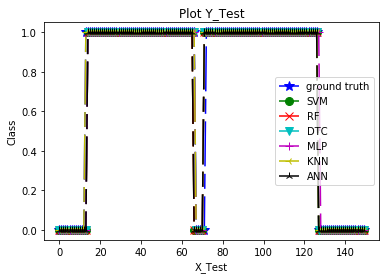

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (6,4))
plt.plot(ground_truth, color='b',dashes =(30,5,10,5), marker = '*', markersize = 10, label = 'ground truth')
plt.plot(svc_result, color='g', dashes =(30,5,10,5), label = 'SVM', marker = 'o', markersize = 8)
plt.plot(rfc_result, color= 'r', dashes =(30,5,10,5), label = 'RF', marker = 'x', markersize = 8)
plt.plot(dtc_result, color= 'c', dashes =(30,5,10,5), label = 'DTC', marker = 'v', markersize = 8)
plt.plot(mlp_result, color='m', dashes =(30,5,10,5), label = 'MLP', marker = '+', markersize = 8)
plt.plot(knn_result, color= 'y', dashes =(30,5,10,5), label = 'KNN', marker = '3', markersize = 8)
plt.plot(ann_result, color= 'k', dashes =(30,5,10,5), label = 'ANN', marker = '2', markersize = 8)
plt.legend()

plt.title("Plot Y_Test")
plt.xlabel("X_Test")
plt.ylabel("Class")
plt.savefig('accuracy.png')
plt.show()

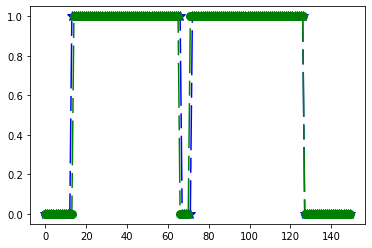

In [18]:
plt.plot(ground_truth, color='b',dashes =(30,5,10,5), marker = '*', markersize = 10, label = 'ground truth')
plt.plot(svc_result, color='g', dashes =(30,5,10,5), label = 'SVM', marker = 'o', markersize = 8)
plt.legend()

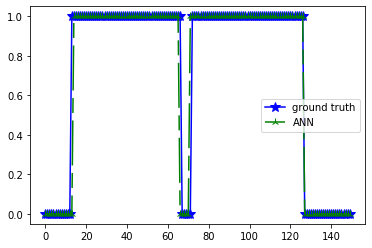

In [22]:
plt.plot(ground_truth, color='b', marker = '*', markersize = 10, label = 'ground truth')
plt.plot(ann_result, color= 'g', dashes =(30,5,10,5), label = 'ANN', marker = '2', markersize = 8)
plt.legend()